CV HW4 License Plate Localization

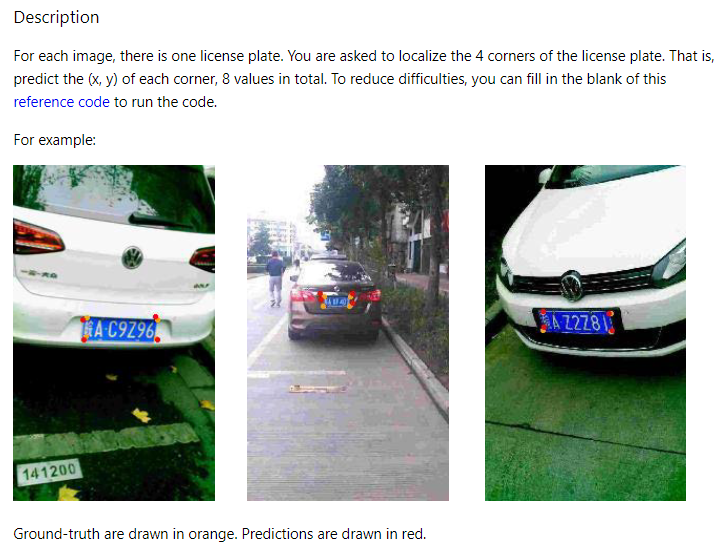

# Download dataset

## method1. upload dataset manually (slow)

In [ ]:
from google.colab import files
uploaded = files.upload()

## method 2. faster way using kaggle command ( please check https://www.kaggle.com/general/74235)

In [2]:
#1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

#2. Click on Create New API Token - It will download kaggle.json file on your machine.

#3. Go to your Google Colab project file and run the following commands:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

## You can put the dataset in Google Drive by running the following commands

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
# unzip dataset
!kaggle competitions download -c computer-vision-hw4-2023
!unzip computer-vision-hw4-2023.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Archive:  computer-vision-hw4-2023.zip


In [4]:
!nvidia-smi

Mon Dec 11 13:54:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Init and Utility

In [5]:
import warnings
import os
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython import display
from skimage import util
from skimage.transform import ProjectiveTransform, warp

import numpy as np
import random
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import torchvision.models as models
import cv2
import shutil
import warnings

In [6]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [7]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

# Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


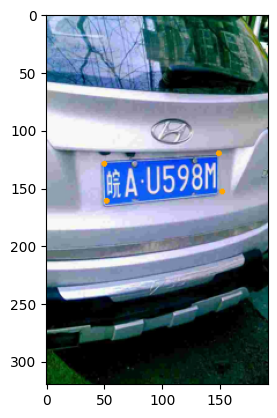

In [8]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of
                bottom-right, bottom-left, top-left, top-right corners.
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)

        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]

        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

# Network

In [9]:
import torch.nn as nn
import torchvision.models as models

class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained ResNet-34 model
        resnet34 = models.resnet34(pretrained=True)

        # Extract only the feature extraction layers from ResNet-34
        self.features = nn.Sequential(
            resnet34.conv1,
            resnet34.bn1,
            resnet34.relu,
            resnet34.layer1,
            resnet34.layer2,
            resnet34.layer3,
            resnet34.layer4,
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Regression layers to predict keypoint positions
        self.regression = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 8)  # Output 8 values for 4 keypoints (x, y) each
        )

    def forward(self, img_b):
        features = self.features(img_b)
        kpt_b = self.regression(features.view(features.size(0), -1))
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)


torch.Size([32, 3, 320, 192])
torch.Size([32, 8])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 45.0MB/s]


tensor(0.4813, device='cuda:0', grad_fn=<MeanBackward0>)


# Training

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can als

lr: 0.0001
Epoch 000:
train loss: 0.06680368525907397
valid loss: 0.029200271666049958
lr: 0.0001
Epoch 001:
train loss: 0.02812145105873545
valid loss: 0.024083548660079637
lr: 0.0001
Epoch 002:
train loss: 0.023304669031252463
valid loss: 0.01757818056891362
lr: 0.0001
Epoch 003:
train loss: 0.01897933801015218
valid loss: 0.01161819498365124
lr: 0.0001
Epoch 004:
train loss: 0.015028026609991987
valid loss: 0.013945698191722235
lr: 0.0001
Epoch 005:
train loss: 0.012819012695302567
valid loss: 0.010186795269449551
lr: 0.0001
Epoch 006:
train loss: 0.011069404071507355
valid loss: 0.011804206209878126
lr: 0.0001
Epoch 007:
train loss: 0.010502980379387737
valid loss: 0.011162412911653518
lr: 0.0001
Epoch 008:
train loss: 0.009706309031074245
valid loss: 0.011451834117372831
lr: 0.0001
Epoch 009:
train loss: 0.009862883533351123
valid loss: 0.008937112881491582
lr: 0.0001
Epoch 010:
train loss: 0.009516187865907947
valid loss: 0.011140394682685534
lr: 0.0001
Epoch 011:
train loss: 0.0

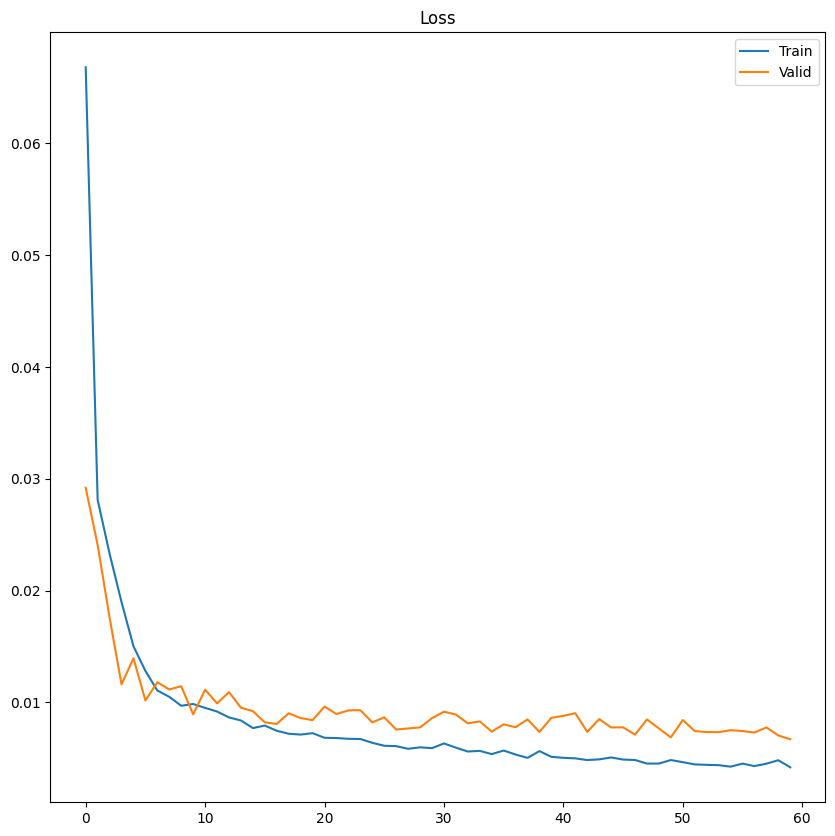

Total parameters: 21,351,368
Trainable parameters: 21,351,368


In [10]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))

        self.train_loader = DataLoader(self.train_set, 8, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 8, shuffle=False, num_workers=4)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)
        self.max_epoch = 60 #TODO define your training epochs

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': []}

        for self.epoch in range(self.max_epoch): # epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            print('lr:',get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_loss']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))

        # Plot the loss curve against epoch
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
        ax.set_title('Loss')
        ax.plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax.plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax.legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

    def train(self):
      self.model.train()
      loss_steps = []

      for img_b, kpt_b in iter(self.train_loader):
          img_b = img_b.to(self.device)
          kpt_b = kpt_b.to(self.device)
          self.optimizer.zero_grad()
          pred_b = self.model(img_b)
          # Step 1: Calculate the loss
          loss = self.criterion(pred_b, kpt_b)
          # Step 2: Backpropagation
          loss.backward()
          # Step 3: Update parameters using optimizer
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
          self.optimizer.step()
          loss_steps.append(loss.detach().item())

      avg_loss = sum(loss_steps) / len(loss_steps)
      return avg_loss

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss_steps.append(loss.detach().item())

        avg_loss = sum(loss_steps) / len(loss_steps)
        return avg_loss

    def count_parameters(self):
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        return total_params, trainable_params

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
trainer_instance = Trainer(log_dir)
trainer_instance.run()

total_params, trainable_params = trainer_instance.count_parameters()
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')


# Testing

In [11]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor
img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
model.eval()

log_dir_test = Path('./testing_result') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('./ccpd6000/test_pred.csv', float_format='%.5f', index=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


testing_result/Dec.11 15:10:04


100%|██████████| 3000/3000 [02:01<00:00, 24.62it/s]


# Report

1.overlay training losses and validation losses in the same figure against each epoch

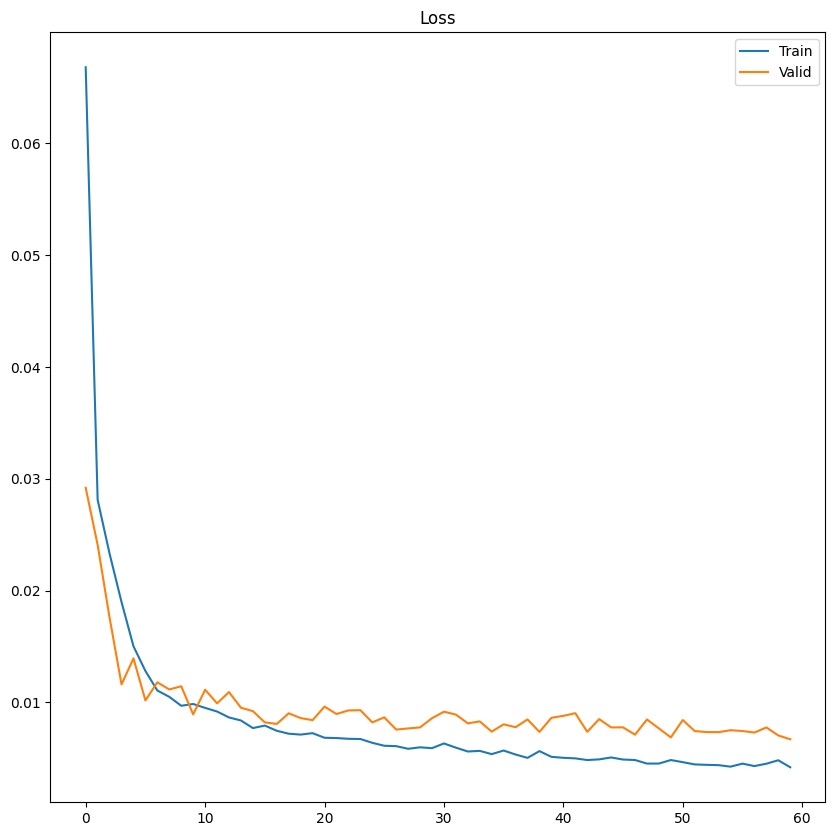

2.Visualization results of your final model on: (1)test_images/0000.jpg, (2)test_images/1000.jpg. Ex:

(1)
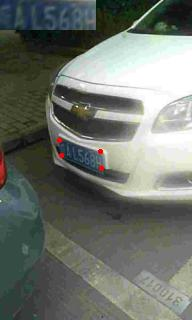

(2)
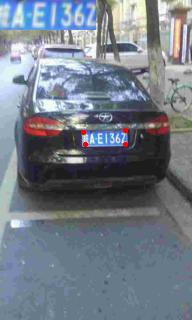

3.The number of total parameters and trainable parameters.

Total parameters: 21,351,368

Trainable parameters: 21,351,368

4.The hyperparameters(epochs, learning rate, loss function, optimizer) of your final model

epochs: 60

learning rate: 0.0001

loss function: L1Loss (the average of the absolute errors between the predicted values and the actual values.)

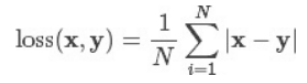

optimizer: Adam(Adaptive Moment Estimation)

In short, it is an RMSprop with momentum, adjusting the learning rates for each parameter dynamically using first-order and second-order moment estimates of the gradients.

The advantage lies in having a fixed range for the learning rate after bias correction, ensuring more stability in each iteration.

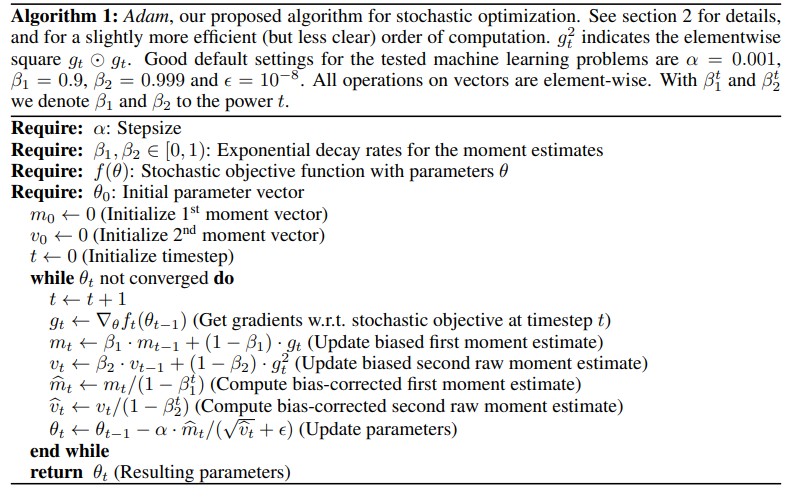

5.Describe and compare the methods you have tried in this project

Although Kaggle indicates that I made 22 attempts, in reality, there were only 20 attempts (as I resubmitted due to not initially knowing that Kaggle retains the best record). During this process, when I used ResNet18 and completed all the TODO parts (without changing the learning rate and keeping epochs <= 20), the result was below the baseline_60. Adjusting the learning rate to 0.0001 and extending the epochs did not lead to significant improvements. Later, I switched to ResNet34 (as using a GPU on Google Colab beyond 50 became unfeasible) and extended the epochs to 60 and even 120, achieving results above baseline_65.

I struggled between baseline_65 and baseline_70 for a long time because adjusting the learning rate around 0.0001 did not yield noticeable changes, and longer epochs did not necessarily lead to better performance. According to experience, it is sufficient to have epochs when both training loss and validation loss converge; there's no need to wait for an extended period. Additionally, I tried changing the loss function to the evaluation RMSE. Although the loss values decreased significantly, the overall performance on Kaggle did not improve and might even worsen. Changing the optimizer to other types did not bring significant changes that could surpass baseline_70.

I was almost giving up because manually tuning hyperparameters was too slow, and Colab GPU had usage limitations. The breakthrough came when I adjusted the batch size. Although I had previously adjusted the batch size without much impact (knowing that a smaller batch size, while requiring more time per epoch, allows the model to learn more intricacies and perform better), I took a moment yesterday to carefully examine the loss curves of the current best-performing model. After researching online, I discovered that when there is still a gap between validation loss and training loss, it indicates there is room for further training, and one should not give up. Some suggestions for hyperparameter adjustments included changing the batch size. Following this insight, I decided to experiment by adjusting the batch size from 10 to 8, and it turned out to be successful.

Based on my experience with this assignment, I believe that next time I shouldn't be so naive to manually adjust everything. Instead, I should try other approaches that allow the algorithm to automatically discover the optimal hyperparameters. This way, I can save a considerable amount of time.

6.Write a report about your method: 

I used ResNet34 as the network architecture(pretrained) and adjusted hyperparameters, setting the learning rate to 0.0001, epochs to 60, and batch size to 8. The rest of the components follow the original template. Training this model takes a considerable amount of time, but since it has already surpassed the baseline 70, I did not explore further. However, I speculate that there is potential for improved performance by finding a more effective learning rate or experimenting with a smaller batch size.